In [1]:
import sys
sys.path.append('..')

from VarPro import *

In [2]:
plt.rcParams.update({"pdf.fonttype": 42, 'text.usetex': True})

# Gaussian convolution in 2d
The model is a convolution with a gaussian kernel in 2d

In [3]:
## Teacher model
scale = 0.5
activation = ActivationFunction(lambda t: 2*torch.exp(-t/scale) / scale**2) ## activation function

w_lim = 2
clipping_function = PeriodicBoundaryCondition(x_min=-w_lim, x_max=w_lim)
clipper = FeatureClipper(clipping_function)

modes = w_lim * torch.tensor([[-0.5, 0], [0.5, 0.5]], dtype=torch.float32)

gamma = 100

if gamma < 0:
    teacher_width = 2
    teacher_weight = modes
else:
    teacher_width = 4096
    teacher_weight = w_lim * torch.tensor(generate_periodic_distribution(teacher_width, dim=2, gamma=gamma), dtype=torch.float32)
    teacher_weight[::2] += modes[0]
    teacher_weight[1::2] += modes[1]


teacher = Convolution(2, teacher_width, activation, clipper=clipper, projection=clipping_function)

teacher.feature_model.weight = nn.Parameter(data=teacher_weight) ## teacher feature distribution
teacher.outer.weight = nn.Parameter(data=torch.ones_like(teacher.outer.weight, dtype=torch.float32)) ## teacher outer weight

teacher.clipper(teacher)
teacher.apply(freeze)

/Users/rbarboni/Documents/GitHub/VarPro/VarPro_convolution_2d/../Utilities.py:97: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.arctan( x[:,1] / (1+x[:,0]))


VarProModel(
  (feature_model): ConvolutionFeatureModel(
    (activation): ActivationFunction()
  )
  (outer): Linear(in_features=4096, out_features=1, bias=False)
)

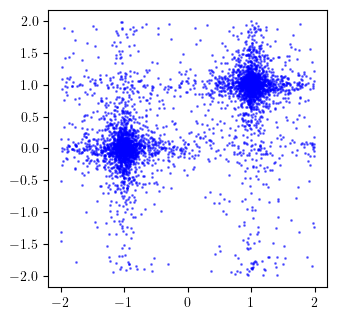

In [ ]:
# plot of the teacher feature distribution
p=0.3
fig, ax = plt.subplots(figsize=(12 * p, 12 * p), constrained_layout=False)

w = teacher.feature_model.weight
ax.scatter(w[:,0], w[:,1], s=1, alpha=0.5, color='blue')
ax.axis('equal')

#fig.savefig('teacher_distribution_2d.pdf', format='pdf', bbox_inches='tight')

In [5]:
# plot of the teacher signal
xx, yy, zz = model_plot_2d(teacher, x_lim=(-w_lim, w_lim), plot=False)

In [6]:
fig = plt

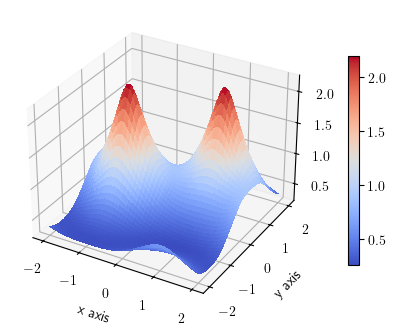

In [ ]:
p=0.3
fig, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(15 * p, 15 * p), constrained_layout=False)

surf = ax.plot_surface(xx, yy, zz, linewidth=0, antialiased=False, cmap=cm.coolwarm)
fig.colorbar(surf, fraction=0.03, pad=0.1)
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')

#fig.savefig('teacher_signal_2d.pdf', format='pdf', bbox_inches='tight')
#plt.title('Teacher signal')

In [106]:
# creating the dataset
N = 4096

inputs = torch.randn(N,2)
targets = teacher(inputs)
dataset = CustomDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

In [107]:
## Student model
student_width = 32
#clipper = FeatureClipper(Normalization())

# uniform initialization
init = w_lim * (2 * torch.rand((student_width, 2), dtype=torch.float32) - 1)

student = Convolution(2, student_width, activation, clipper=clipper, VarProTraining=True, projection=clipping_function)

student.feature_model.weight = nn.Parameter(data=init.clone().detach(), requires_grad=True)
student.clipper(student)

In [108]:
inputs, targets = next(iter(train_loader))
features = student.feature_model(inputs).clone().detach()

K = features.T @ features / (N * student_width)

In [109]:
torch.linalg.norm(K, ord=2) # should be close to 1

tensor(0.6843)

In [110]:
## Training
lmbda = 1e-3
time_scale = 2**(-10)
lr = student_width * time_scale

# biased or unbiased loss
criterion = VarProCriterionUnbiased(lmbda)

## one projection to set-up outer layer
inputs, targets = next(iter(train_loader))
criterion.projection(inputs, targets, student)
                                   
optimizer = torch.optim.SGD([student.feature_model.weight], lr=lr)
#optimizer.add_param_group({'lr': 5*student_width*lmbda, 'params': student.outer.weight})

In [111]:
problem = LearningProblem(student, train_loader, optimizer, criterion)

In [112]:
epochs = 5000
problem.train(epochs)

log10(loss) = -1.07: 100%|██████████| 5000/5000 [01:12<00:00, 69.40it/s]


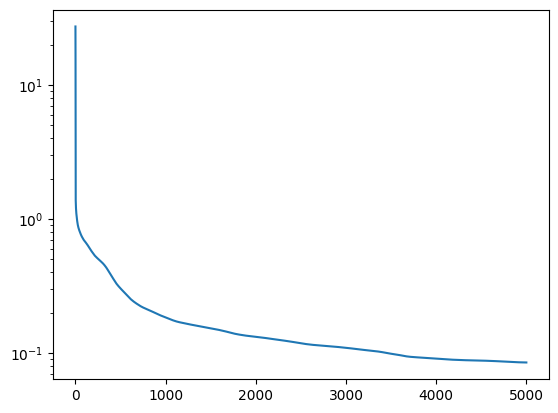

In [113]:
# training loss
plt.plot(problem.loss_list)
plt.yscale('log')
#plt.xscale('log')

#### Distance to the teacher distribution

In [66]:
distance_teacher_list = []
distance_teacher_idx = [int(i) for i in np.linspace(0, len(problem.state_list)-1, 1001)]
for i in tqdm(distance_teacher_idx):
    w1 = problem.state_list[i]['feature_model.weight']
    w2 = teacher.feature_model.weight
    distance_teacher_list.append(compute_distance(DistanceMMD(projection=clipping_function), w1, w2).item())


100%|██████████| 1001/1001 [00:03<00:00, 270.69it/s]


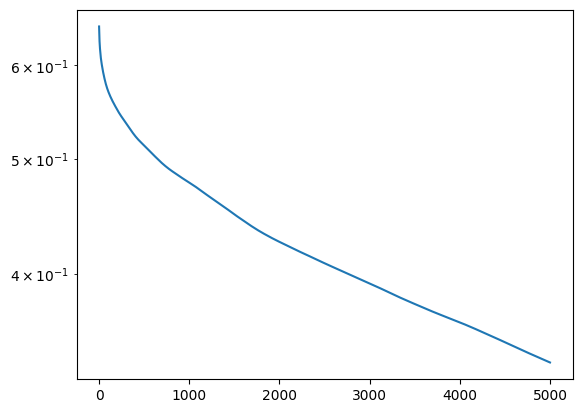

In [67]:
plt.plot(distance_teacher_idx, distance_teacher_list)
plt.yscale('log')
#plt.xscale('log')

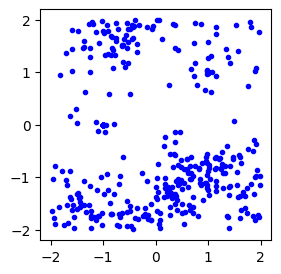

In [68]:
w_array = np.array([dico['feature_model.weight'].numpy() for dico in problem.state_list]) 

weight_animation_2d(w_array, name='Convolution_2d_animation.mp4')